In [ ]:
!pip install deepdish
!pip install numpy==1.15.4

     |████████████████████████████████| 13.9MB 250kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.15.4 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.1 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
#from tqdm import tqdm
#from glob import glob
#import seaborn as sns
#import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

#import itertools

#import cv2
#from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Proyecto Curso Samsung')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [6]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [7]:
X = np.zeros((10015, 75, 100, 3))

for i in range(10015):
  X[i,:,:,:] = X_raw[i]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

In [9]:
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))
X_val = (X_val / np.max(X_val))

In [10]:
Y_train = to_categorical(Y_train, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)
Y_val = to_categorical(Y_val, num_classes = 7)

In [11]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [12]:

input_shape = X_train[0].shape
n_classes = len(Y_train[0])

resnet = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
resnet.trainable = False

model = tf.keras.models.Sequential()
model.add(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))    
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

234553344/234545216 [==============================] - 2s 0us/step


In [13]:
epocas = 50
bs = 20
lr = 0.001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "ph1_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint]

In [14]:
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, batch_size = bs, validation_data = (X_val, Y_val), callbacks = callbacks)
#historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.1, callbacks = callbacks)

Epoch 1/50
361/361 [==============================] - ETA: 0s - loss: 1.5970 - accuracy: 0.5236
Epoch 00001: val_loss improved from inf to 0.90617, saving model to ph1_weights.hdf5
361/361 [==============================] - 31s 85ms/step - loss: 1.5970 - accuracy: 0.5236 - val_loss: 0.9062 - val_accuracy: 0.6983
Epoch 2/50
361/361 [==============================] - ETA: 0s - loss: 1.0757 - accuracy: 0.6506
Epoch 00002: val_loss improved from 0.90617 to 0.82311, saving model to ph1_weights.hdf5
361/361 [==============================] - 26s 72ms/step - loss: 1.0757 - accuracy: 0.6506 - val_loss: 0.8231 - val_accuracy: 0.7107
Epoch 3/50
361/361 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.6728
Epoch 00003: val_loss did not improve from 0.82311
361/361 [==============================] - 22s 61ms/step - loss: 0.9848 - accuracy: 0.6728 - val_loss: 0.8248 - val_accuracy: 0.7219
Epoch 4/50
361/361 [==============================] - ETA: 0s - loss: 0.9308 - accuracy:

In [15]:
model.load_weights(best_weights_ph1)

In [16]:
metricas = model.evaluate(X_test, Y_test)

63/63 [==============================] - 4s 61ms/step - loss: 0.7516 - accuracy: 0.7329


In [17]:
resnet.trainable = True

epocas = 30
bs = 20
lr = 0.0001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph2 = "ph2_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint]

In [18]:
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, batch_size = bs, validation_data = (X_val, Y_val), callbacks = callbacks)

Epoch 1/30
361/361 [==============================] - ETA: 0s - loss: 0.8630 - accuracy: 0.6908
Epoch 00001: val_loss improved from inf to 0.70584, saving model to ph2_weights.hdf5
361/361 [==============================] - 76s 210ms/step - loss: 0.8630 - accuracy: 0.6908 - val_loss: 0.7058 - val_accuracy: 0.7456
Epoch 2/30
361/361 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.7209
Epoch 00002: val_loss improved from 0.70584 to 0.64263, saving model to ph2_weights.hdf5
361/361 [==============================] - 65s 181ms/step - loss: 0.7625 - accuracy: 0.7209 - val_loss: 0.6426 - val_accuracy: 0.7693
Epoch 3/30
361/361 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.7344
Epoch 00003: val_loss improved from 0.64263 to 0.61073, saving model to ph2_weights.hdf5
361/361 [==============================] - 65s 180ms/step - loss: 0.7289 - accuracy: 0.7344 - val_loss: 0.6107 - val_accuracy: 0.7805
Epoch 4/30
361/361 [===========================

In [19]:
model.load_weights(best_weights_ph2)

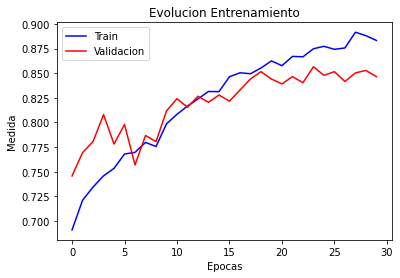

In [20]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

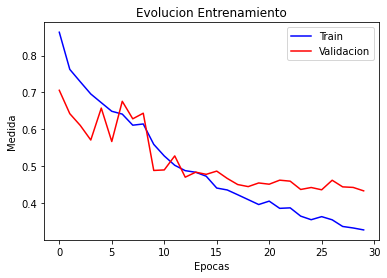

In [21]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [22]:
metricas = model.evaluate(X_test, Y_test)

63/63 [==============================] - 4s 58ms/step - loss: 0.4776 - accuracy: 0.8402
